Shape after filtering: (2085, 682, 224)


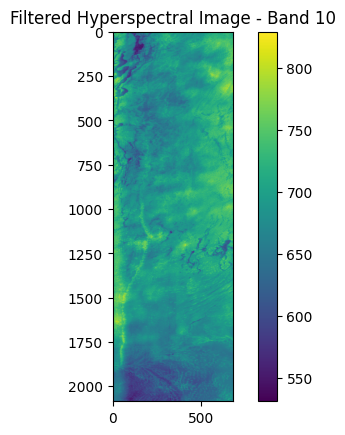

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Load the hyperspectral data
hyperspectral_data = scipy.io.loadmat(r"C:\Users\Soham\Downloads\Hyper1.mat")
hyperspectral_data = hyperspectral_data['img']  # Ensure the key is correct
height, width, bands = hyperspectral_data.shape

# Fixing the filtering issue (selecting all bands for now)
# To filter specific bands, use indexing or other criteria.
filtered_data = hyperspectral_data  # No filtering for now

print(f"Shape after filtering: {filtered_data.shape}")

# Ensure the band index is valid
band_index = 10  # Change to a valid index between 0 and bands-1
if band_index < 0 or band_index >= bands:
    raise ValueError(f"Invalid band index: {band_index}. Must be between 0 and {bands-1}.")

# Extract and display a specific band
band = filtered_data[:, :, band_index]
plt.imshow(band)
plt.colorbar()
plt.title(f'Filtered Hyperspectral Image - Band {band_index}')
plt.show()


In [15]:
from scipy.io import loadmat

# Load the .mat file
file_path = r"C:\Users\Soham\Downloads\Hyper1.mat"  # Replace with your file path
data = loadmat(file_path)

# Inspect the keys (variables stored in the file)
print("Keys in .mat file:", data.keys())


Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'img', 'map'])


In [16]:
filtered_data[943][433]

array([-351, -333,  482,  529,  586,  771,  827,  836,  792,  756,  716,
        658,  618,  579,  549,  515,  487,  457,  428,  404,  379,  346,
        323,  290,  271,  251,  241,  222,  213,  208,  202,  192,  191,
        183,  174,  154,  131,  130,  118,   88,  103,  102,  110,   86,
         91,   94,   92,   80,   83,   66,   65,   72,   84,   76,   77,
         69,   65,   50,   33,   25,   16,  -13, -207,  -77,   24,   33,
         45,   56,   61,   66,   69,   63,   62,   57,   61,   46,   38,
         30,   15,  -11,  -71,  -75,  -82,  -77,  -27,    6,   14,   18,
         27,   19,   25,   28,   36,   39,   39,   44,   40,   46,   24,
         30,   25,   12,   23,  -50,  -53, -109,    0,    0,    0,    0,
          0,    0,    0,  -31,   -2,  -75,  -29,   -8,  -27,  -27,  -11,
          1,    4,   14,   17,   17,   21,   18,   23,   23,   24,   19,
         20,   24,   29,   19,   23,   17,   15,   23,   21,   20,   27,
         12,   11,   20,    8,    5,    0,    6,  -

In [17]:
header = data['__header__']
version = data['__version__']
globals = data['__globals__']


print("Header:", header)
print("Version:", version)
print("Globals:", globals)


Header: b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Dec 31 20:26:22 2020'
Version: 1.0
Globals: []


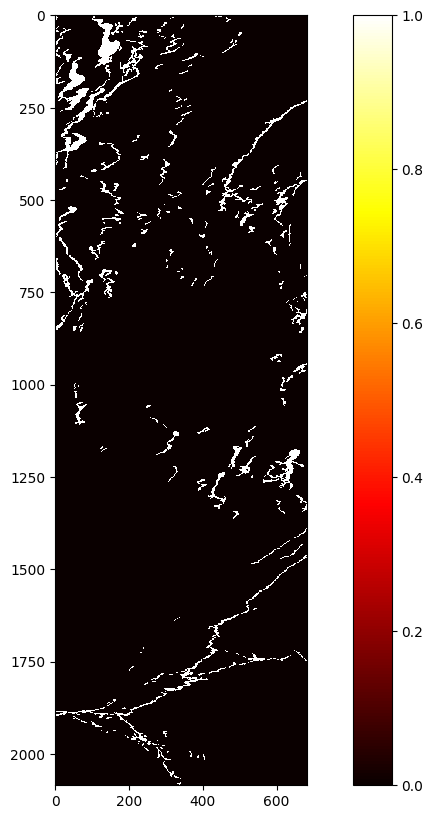

In [18]:
map = data['map']
plt.figure(figsize=(12, 10))
plt.imshow(map, cmap='hot', interpolation='nearest')
plt.colorbar(label='')
#plt.title('Mean Saliency Map for Hyperspectral Data')
#plt.xlabel('Pixel X-axis')
#plt.ylabel('Pixel Y-axis')
plt.show()


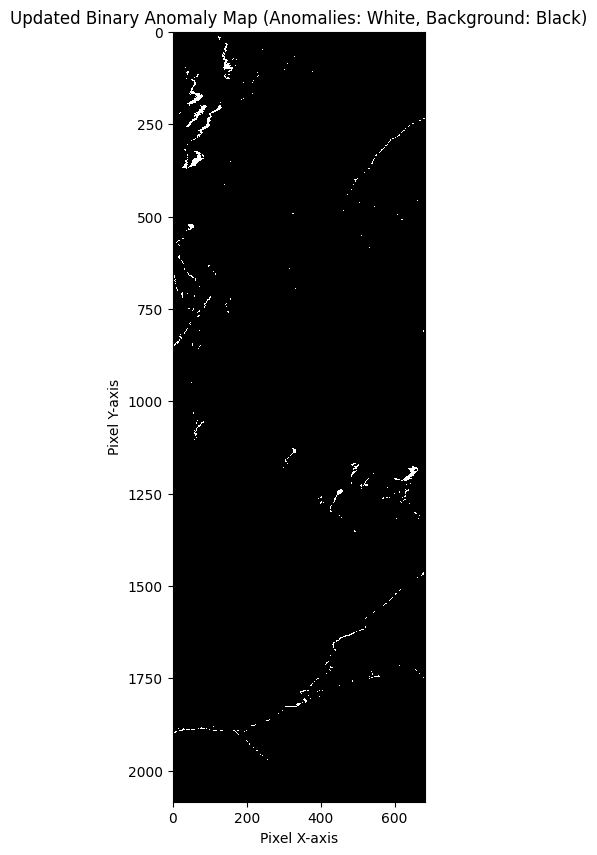

In [3]:
import numpy as np
from skimage.morphology import closing, opening, square
from skimage.filters import threshold_otsu
from skimage import exposure
import matplotlib.pyplot as plt

def multi_scale_saliency(filtered_data, scales=[3, 5, 7, 9], batch_size=50):
    """
    Compute saliency map over multiple scales using morphological operations with memory optimization.

    Parameters:
        filtered_data (numpy.ndarray): 3D hyperspectral data array (height, width, bands).
        scales (list): List of structuring element sizes to apply at different scales.
        batch_size (int): Number of spectral bands to process in one batch.

    Returns:
        numpy.ndarray: Combined saliency map from multiple scales.
    """
    multi_scale_saliency_map = np.zeros_like(filtered_data[:, :, 0], dtype=np.float32)

    for scale in scales:
        selem = square(scale)
        for i in range(0, filtered_data.shape[2], batch_size):
            band_batch = filtered_data[:, :, i:i+batch_size]
            closed_hsi = np.zeros_like(band_batch, dtype=np.float32)
            opened_hsi = np.zeros_like(band_batch, dtype=np.float32)

            for j in range(band_batch.shape[2]):
                closed_hsi[:, :, j] = closing(band_batch[:, :, j], selem)
                opened_hsi[:, :, j] = opening(band_batch[:, :, j], selem)

            saliency_map = np.abs(band_batch - opened_hsi) + np.abs(band_batch - closed_hsi)
            saliency_map_normalized = exposure.rescale_intensity(saliency_map, out_range=(0, 1))
            multi_scale_saliency_map += np.mean(saliency_map_normalized, axis=2)

    return multi_scale_saliency_map / len(scales)

def otsu_thresholding(saliency_map, threshold_adjustment=0.1):
    """
    Apply Otsu's method to threshold the saliency map.

    Parameters:
        saliency_map (numpy.ndarray): Saliency map to be thresholded.
        threshold_adjustment (float): Adjustment factor for the computed threshold.

    Returns:
        numpy.ndarray: Binary map after thresholding.
    """
    threshold = threshold_otsu(saliency_map)
    return saliency_map > (threshold + threshold_adjustment)

def spectral_difference_map(filtered_data):
    """
    Compute a basic spectral difference map for additional saliency refinement.

    Parameters:
        filtered_data (numpy.ndarray): 3D hyperspectral data array.

    Returns:
        numpy.ndarray: Spectral difference map.
    """
    return np.std(filtered_data, axis=2)

def smooth_saliency_map(refined_saliency_map, sigma=1):
    """
    Smooth the saliency map using Gaussian smoothing.

    Parameters:
        refined_saliency_map (numpy.ndarray): Refined saliency map.
        sigma (float): Standard deviation for Gaussian smoothing.

    Returns:
        numpy.ndarray: Smoothed saliency map.
    """
    from scipy.ndimage import gaussian_filter
    return gaussian_filter(refined_saliency_map, sigma=sigma)

def saliency(filtered_data, scales=[3, 5, 7, 9], sigma=1, threshold_adjustment=0.1):
    """
    Compute saliency map and separate anomalies based on the background.

    Parameters:
        filtered_data (numpy.ndarray): 3D hyperspectral data array (height, width, bands).
        scales (list): List of structuring element sizes for multi-scale operations.
        sigma (float): Standard deviation for Gaussian smoothing.
        threshold_adjustment (float): Adjustment for Otsu's thresholding.

    Returns:
        numpy.ndarray: Binary saliency map.
    """
    filtered_data = filtered_data.astype(np.float32)

    # Multi-scale saliency map
    multi_scale_map = multi_scale_saliency(filtered_data, scales=scales)

    # Spectral difference map
    spectral_diff_map = spectral_difference_map(filtered_data)
    refined_saliency_map = multi_scale_map + spectral_diff_map

    # Smooth the saliency map
    smoothed_saliency_map = smooth_saliency_map(refined_saliency_map, sigma=sigma)

    # Thresholding with adjustment
    binary_saliency_map = otsu_thresholding(smoothed_saliency_map, threshold_adjustment)

    return binary_saliency_map

# Adjust parameters and test
# Assume `filtered_data` is already loaded
binary_anomaly_map = saliency(
    filtered_data=filtered_data,
    scales=[3, 5, 7, 9],
    sigma=0.05,
    threshold_adjustment=0.005

    
)

# Visualize the updated binary anomaly map
plt.figure(figsize=(12, 10))
plt.imshow(binary_anomaly_map, cmap='gray', interpolation='nearest')
plt.title('Updated Binary Anomaly Map (Anomalies: White, Background: Black)')
plt.xlabel('Pixel X-axis')
plt.ylabel('Pixel Y-axis')
plt.show()


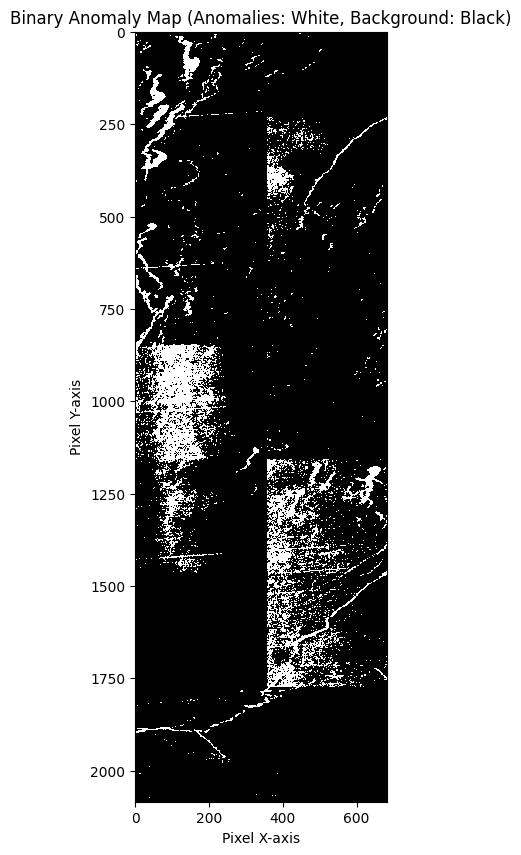

In [6]:
binary_anomaly_map = np.zeros_like(mean_saliency_map, dtype=np.uint8)
threshold = np.percentile(mean_saliency_map, saliency_percentile)
binary_anomaly_map[mean_saliency_map >= threshold] = 1
binary_anomaly_map[mean_saliency_map < threshold] = 0

# Visualize the binary anomaly map
plt.figure(figsize=(12, 10))
plt.imshow(binary_anomaly_map, cmap='gray', interpolation='nearest')
plt.title('Binary Anomaly Map (Anomalies: White, Background: Black)')
plt.xlabel('Pixel X-axis')
plt.ylabel('Pixel Y-axis')
plt.show()


In [21]:
binary_anomaly_map

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,

In [5]:
#Have to run
import torch
import torch.nn as nn
import torch.optim as optim

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


input_dim = 224  # Background feature size
#have to try reducing this 
latent_dim = 64  # Latent vector size 
batch_size = 64
epochs = 50
#try 
lr = 0.0002

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class LatentDiscriminator(nn.Module):
    def __init__(self, latent_dim):
        super(LatentDiscriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Discriminator for reconstructed input
class ReconstructionDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(ReconstructionDiscriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize models
encoder = Encoder(input_dim, latent_dim).to(device)
decoder = Decoder(latent_dim, input_dim).to(device)
latent_discriminator = LatentDiscriminator(latent_dim).to(device)
reconstruction_discriminator = ReconstructionDiscriminator(input_dim).to(device)

mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

opt_encoder_decoder = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
opt_latent_discriminator = optim.Adam(latent_discriminator.parameters(), lr=lr)
opt_reconstruction_discriminator = optim.Adam(reconstruction_discriminator.parameters(), lr=lr)



Using device: cuda


In [50]:
#Training process (No need to run)

features_min = torch.min(torch.tensor([item[0] for item in DTrn], dtype=torch.float32).to(device), dim=0, keepdim=True)[0]
features_max = torch.max(torch.tensor([item[0] for item in DTrn], dtype=torch.float32).to(device), dim=0, keepdim=True)[0]

def normalize(features, min_val, max_val):
    return (features - min_val) / (max_val - min_val)

def denormalize(features, min_val, max_val):
    return features * (max_val - min_val) + min_val

#havent normalized the feature, have to try this as well :)
for epoch in range(epochs):
    for i in range(0, len(DTrn), batch_size):
        batch_data = DTrn[i:i + batch_size]
        features = torch.tensor([item[0] for item in batch_data], dtype=torch.float32).to(device)
        #normalized_features = normalize(features, features_min, features_max)

        # Encode 
        z_real = encoder(features)
        x_reconstructed = decoder(z_real)

        

        # Latent - Discriminator Training
        z_prior = torch.randn(batch_size, latent_dim).to(device)  # Prior Gaussian distribution
        d_z_real = latent_discriminator(z_real.detach())
        d_z_fake = latent_discriminator(z_prior)
        loss_d_z = bce_loss(d_z_real, torch.ones_like(d_z_real)) + \
                   bce_loss(d_z_fake, torch.zeros_like(d_z_fake))

        opt_latent_discriminator.zero_grad()
        loss_d_z.backward()
        opt_latent_discriminator.step()

        # Reconstruction-Discriminator Training
        recon_z_fake = decoder(z_prior)
        d_x_real = reconstruction_discriminator(features)
        d_x_fake = reconstruction_discriminator(recon_z_fake.detach())
        loss_d_x = bce_loss(d_x_real, torch.ones_like(d_x_real)) + \
                   bce_loss(d_x_fake, torch.zeros_like(d_x_fake))

        opt_reconstruction_discriminator.zero_grad()
        loss_d_x.backward()
        opt_reconstruction_discriminator.step()

        # Generator Training
        g_loss_reconstruction = mse_loss(x_reconstructed, features)  # Reconstruction loss
        g_loss_latent = bce_loss(latent_discriminator(z_real), torch.ones_like(d_z_real))  # Fool latent discriminator
        g_loss_reconstructed = bce_loss(reconstruction_discriminator(x_reconstructed), torch.ones_like(d_x_real))  # Fool reconstruction discriminator

        loss_g = g_loss_reconstruction + g_loss_latent + g_loss_reconstructed

        opt_encoder_decoder.zero_grad()
        loss_g.backward()
        opt_encoder_decoder.step()

    # Logging progress
    print(f"Epoch [{epoch + 1}/{epochs}], Loss D_Z: {loss_d_z.item():.4f}, Loss D_X: {loss_d_x.item():.4f}, Loss G: {loss_g.item():.4f}")

print("Training Complete")


Epoch [1/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 321.6596
Epoch [2/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 183.4739
Epoch [3/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 125.3193
Epoch [4/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 79.7757
Epoch [5/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 73.8706
Epoch [6/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 66.8821
Epoch [7/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 46.5491
Epoch [8/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 59.7796
Epoch [9/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 47.1896
Epoch [10/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 47.0161
Epoch [11/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 41.0802
Epoch [12/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 38.2269
Epoch [13/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 37.0375
Epoch [14/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 32.4967
Epoch [15/50], Loss D_Z: 0.0000, Loss D_X: 0.0000, Loss G: 28.5575
E

KeyboardInterrupt: 

In [51]:
# Save the encoder and decoder models after training
torch.save(encoder.state_dict(), "encoder_new.pth")
torch.save(decoder.state_dict(), "decoder_new.pth")


In [5]:
scipy.io.savemat('filtered_data.mat', {'img': filtered_data})

C:\Users\Soham\AppData\Local\Temp\ipykernel_31172\1687404962.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("encoder_new.pth"))
C:\Us

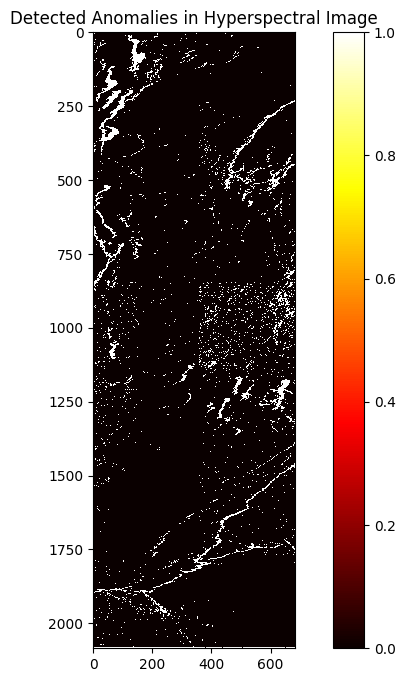

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the encoder and decoder models
encoder.load_state_dict(torch.load("encoder_new.pth"))
decoder.load_state_dict(torch.load("decoder_new.pth"))
encoder.to(device)
decoder.to(device)

filtered_data = scipy.io.loadmat(r'filtered_data.mat')
filtered_data = filtered_data['img']  # Ensure the key is correct

# Assuming DTest is your hyperspectral test data with shape (400, 400, 189)
# Reshape the test data to be (400*400, 189) for feeding into the model
test_data = filtered_data.reshape(-1, 224)  # Shape will be (160000, 189) (flatten each pixel)

# Convert the reshaped data to a tensor and move it to the appropriate device
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)

# Pass the test data through the encoder and decoder
with torch.no_grad():
    z_test = encoder(test_data_tensor)  # Get the encoded representation
    x_reconstructed = decoder(z_test)  # Reconstruct the hyperspectral data

# Compute the reconstruction error (Mean Squared Error) per pixel
reconstruction_error = torch.mean((test_data_tensor - x_reconstructed) ** 2, dim=1)

# Set a threshold for anomaly detection (e.g., 95th percentile of the reconstruction error)
threshold = torch.quantile(reconstruction_error, 0.95)

# Detect anomalies (where reconstruction error exceeds the threshold)
anomalies = reconstruction_error > threshold

# Reshape the anomalies to match the spatial dimensions of the image (400, 400)
reshaped_anomalies = anomalies.cpu().numpy().reshape(2085, 682)

# Visualize the anomalies in the hyperspectral image
plt.figure(figsize=(10, 8))
plt.imshow(reshaped_anomalies, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Detected Anomalies in Hyperspectral Image')
plt.show()


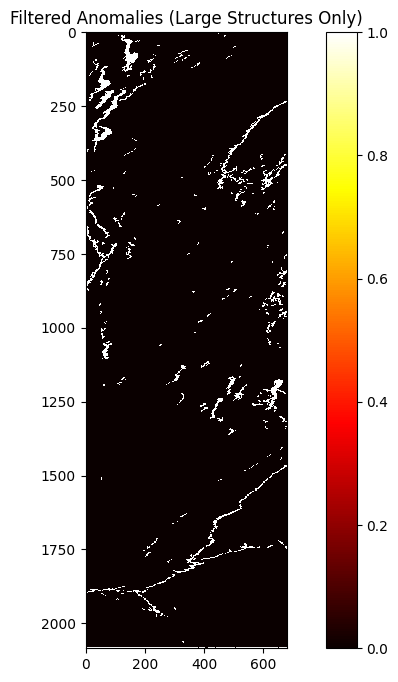

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects

# Load your anomaly map (e.g., 'reshaped_anomalies' from the output above)
anomaly_map = reshaped_anomalies  # Assuming this is your binary map (400x400)

# Label connected components
labeled_map, num_features = label(anomaly_map)

# Filter out small components
size_threshold = 30  # Adjust this threshold based on the size of your plane
filtered_map = np.zeros_like(labeled_map)

for i in range(1, num_features + 1):
    region = (labeled_map == i)
    if np.sum(region) >= size_threshold:
        filtered_map[region] = 1

# Visualize the filtered anomaly map
plt.figure(figsize=(10, 8))
plt.imshow(filtered_map, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Filtered Anomalies (Large Structures Only)')
plt.show()


In [12]:
import numpy as np

# Example maps

# Total elements (size of the map)
total_elements = map.size

# Correct matches (where filtered_map matches map)
matching_elements = np.sum(filtered_map == map)

# Calculate accuracy
accuracy = (matching_elements / total_elements) * 100

# Display the result
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 97.75%


In [15]:
map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

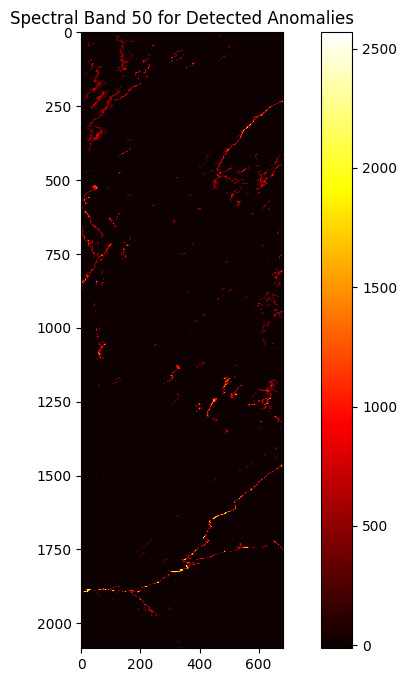

Masked data saved as .mat at: anomaly_spectral_data.mat


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat

# Assuming `filtered_map` is the binary anomaly mask with dimensions (2085, 682)
# Assuming `filtered_data` is the hyperspectral data with dimensions (2085, 682, 224)

# Expand the dimensions of the binary mask to match the hyperspectral data
binary_mask = np.expand_dims(filtered_map, axis=-1)  # Shape becomes (2085, 682, 1)

# Broadcast the mask to match the hyperspectral data dimensions
binary_mask = np.tile(binary_mask, (1, 1, 224))  # Shape becomes (2085, 682, 224)

# Apply the mask to the hyperspectral data
masked_data = filtered_data * binary_mask  # Element-wise multiplication

# Convert masked data to int16
masked_data_int16 = masked_data.astype(np.int16)

# Visualize a specific spectral band for anomalies (e.g., band 50)
plt.figure(figsize=(10, 8))
plt.imshow(masked_data_int16[:, :, 50], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Spectral Band 50 for Detected Anomalies')
plt.show()

# Save the masked data for further analysis in .mat format
output_file_path_mat = "anomaly_spectral_data.mat"
savemat(output_file_path_mat, {'masked_data': masked_data_int16})

print(f"Masked data saved as .mat at: {output_file_path_mat}")


In [31]:
import numpy as np

# Assuming ground_truth and binary_anomaly_map are numpy arrays of shape (H, W)
# ground_truth: 1 for anomalies, 0 for background
# binary_anomaly_map: 1 for detected anomalies, 0 for detected background

# Calculate metrics
TP = np.sum((binary_anomaly_map == 1) & (map == 1))  # True Positives
TN = np.sum((binary_anomaly_map == 0) & (map == 0))  # True Negatives
FP = np.sum((binary_anomaly_map == 1) & (map == 0))  # False Positives
FN = np.sum((binary_anomaly_map == 0) & (map == 1))  # False Negatives

# Compute accuracy, precision, recall, F1-score, and IoU
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"IoU: {iou:.4f}")


Accuracy: 0.8136
Precision: 0.2738
Recall: 0.6648
F1-Score: 0.3879
IoU: 0.2406


In [28]:
import numpy as np

# Assuming ground_truth and binary_anomaly_map are numpy arrays of shape (H, W)
# ground_truth: 1 for anomalies, 0 for background
# binary_anomaly_map: 1 for detected anomalies, 0 for detected background

# Calculate metrics
TP = np.sum((filtered_map == 1) & (map == 1))  # True Positives
TN = np.sum((filtered_map == 0) & (map == 0))  # True Negatives
FP = np.sum((filtered_map == 1) & (map == 0))  # False Positives
FN = np.sum((filtered_map == 0) & (map == 1))  # False Negatives

# Compute accuracy, precision, recall, F1-score, and IoU
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"IoU: {iou:.4f}")


Accuracy: 0.9775
Precision: 0.8429
Recall: 0.6268
F1-Score: 0.6962
IoU: 0.5340


In [12]:
from scipy.io import savemat

output_file_path_mat = "booleanmap.mat"
savemat(output_file_path_mat, {'img': filtered_map})
